## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler,LabelEncoder


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
tf.__version__

'2.5.0'

## easure Data

In [3]:
# !wget https://github.com/dcolinmorgan/AXA_AE_app/blob/main/AE_AXA_poll-ae.parquet?raw=true
data=pd.read_parquet('AE_AXA_poll-ae.parquet')#?raw=true')

# !wget https://github.com/dcolinmorgan/AXA_AE_app/blob/main/edmond_datasets.pickle?raw=true
# data=pd.read_pickle('edmond_datasets.pickle?raw=true')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

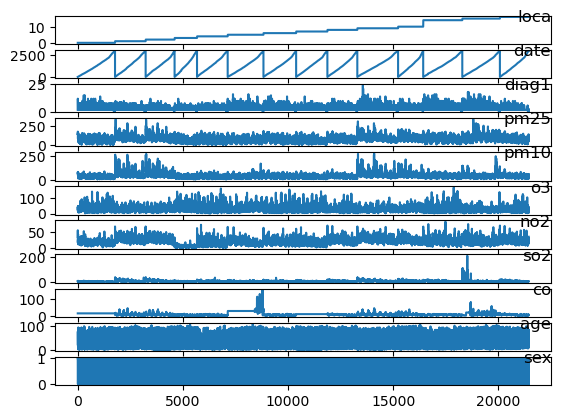

In [6]:
# data=pd.read_parquet('/content/AE_AXA_poll-ae.parquet?raw=true')
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
data['loca']=data.groupby('cd9_loc').ngroup()
data2=pd.DataFrame()
for loc in np.unique(data.loca):
    # data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
    
    datum=data[data['loca']==loc]
    datum=datum.groupby(['loca','date','cd9_loc']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
    datum.reset_index(inplace=True)
    idx = pd.date_range(min(data['date']), max(data['date']))
    datum.index = pd.DatetimeIndex(datum['date'])#.fillna()

    # s.index = pd.DatetimeIndex(s.index)

    datum = datum.reindex(idx, fill_value=np.nan)
    datum['date']=datum.index
    datum['loca']=loc #fillna(method='ffill',inplace=True)
    if datum['pm25'].isna().sum() < 2922/1.5: 
        data2=pd.concat([data2,datum],axis=0)
# data2['date']=data2.index
data=data2
# data['loca'].fillna(method='ffill',inplace=True)
# data.reset_index(inplace=True)
# data['loca']=data.groupby('cd9_loc').ngroup()
data['date']=(data['date']-data['date'][0]).dt.days

data=data[['loca','cd9_loc','date','pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
data=data.groupby(['loca','cd9_loc','date']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]

data.age=np.round(data.age)
data.sex=np.round(data.sex)
data.sort_values(by=['loca','date'],inplace=True)
first_column = data.pop('diag1')
data.insert(0, 'diag1', first_column)
data.reset_index(inplace=True)
data.fillna(method='bfill',inplace=True)
data.fillna(method='ffill',inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
dataset = data.drop(['cd9_loc'],axis=1).values #scaler.fit_transform(data.drop(['cd9_loc'],axis=1))
cc=data['cd9_loc']
# dataset = data.drop(['cd9_loc'],axis=1).values
data=pd.DataFrame(dataset)
data.columns=['loca','date','diag1','pm25','pm10','o3','no2','so2','co','age','sex']
data['cd9_loc']=cc

# specify columns to plot
groups = [0, 1,2, 3, 4, 5, 6, 7, 8,9,10]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(dataset[:, group])
	plt.title(data.drop('cd9_loc',axis=1).columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## Graph data

In [7]:
import geopy.distance
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]

In [8]:
data_loc=df_loc
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))

square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)



In [9]:
data_loc

,lat,long,name,latlon
0,22.458521,114.174913,Alice Ho Miu Ling Nethersole Hospital,"(22.458520800000002, 114.17491344419454)"
1,22.341558,114.153398,Caritas Medical Centre,"(22.341558050000003, 114.15339782752619)"
2,22.315031,114.172051,Kwong Wah Hospital,"(22.3150313, 114.17205092613689)"
3,22.496713,114.124199,North District Hospital,"(22.4967135, 114.12419914862278)"
4,22.28233,113.939258,North Lantau Hospital,"(22.28232965, 113.93925792191538)"
5,22.270224,114.23677,Pamela Youde Nethersole Eastern Hospital,"(22.270223899999998, 114.23677042695417)"
6,22.445444,114.041639,Pok Oi Hospital,"(22.445443750000003, 114.04163866207205)"
7,22.379594,114.202203,Prince of Wales Hospital,"(22.37959355, 114.20220259767265)"
8,22.341238,114.134576,Princess Margaret Hospital,"(22.3412376, 114.13457622780692)"
9,22.30902,114.174388,Queen Elizabeth Hospital,"(22.30901965, 114.17438803791215)"


In [10]:

def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T


In [11]:

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)
distances.shape

(14, 14)

In [12]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [13]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = .99998
adjacency_matrix = compute_adjacency_matrix(distances, sigma2, epsilon)

# distances=np.random.permutation(distances)

# adjacency_matrix =np.where(distances > 15, 0, 1)

# adjacency_matrix=np.ones(distances.shape)

node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 14, number of edges: 90


<Figure size 800x800 with 0 Axes>

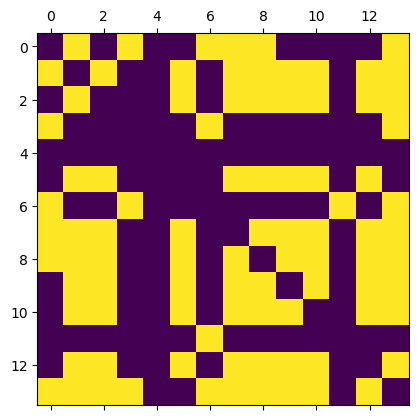

In [14]:
plt.figure(figsize=(8, 8))
plt.matshow((adjacency_matrix))

## LSTM data

In [10]:
# measures_array=data.pivot_table(values=['pm25','pm10','o3','no2','so2','co'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill')
# measures_array=measures_array.dropna().values
# measures_array=measures_array.reshape([measures_array.shape[0],14,6])
# measures_array.shape

In [15]:
measures_array=data.pivot_table(values=['pm25','pm10','o3','no2','co','so2','age','sex'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill')
measures_array=measures_array.dropna().values
measures_array=measures_array.reshape([measures_array.shape[0],8,14])
measures_array=np.transpose(measures_array, [0, 2, 1])
# cc=measures_array[:,:,2]
# measures_array[:,:,0]=measures_array[:,:,2] ## move diag1 to 0 index
# measures_array[:,:,2]=cc
measures_array.shape ##age will be predicted here

(2908, 14, 8)

In [16]:
# plt.plot(measures_array[:,:,0]) ## check diag1 is 0 index 3rd dim

In [17]:
# measures_array=data.pivot_table(values=['pm10'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill').values
# measures_array.shape

In [18]:
np.isfinite(measures_array).all()


True

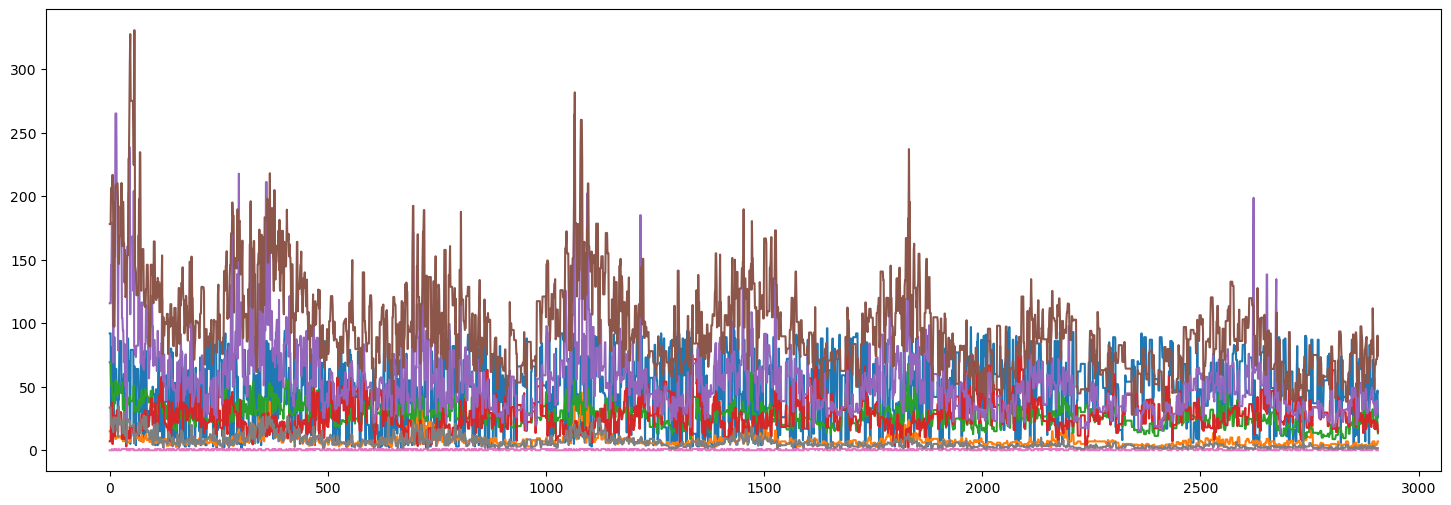

In [19]:
plt.figure(figsize=(18, 6))
plt.plot(measures_array[:,1])
# plt.legend(["route_0", "route_25"])

In [20]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array )#- mean) / std
    val_array = (data_array[num_train : (num_train + num_val)])# - mean) / std
    test_array = (data_array[(num_train + num_val) :])# - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(measures_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (1454, 14, 8)
validation set size: (581, 14, 8)
test set size: (873, 14, 8)


In [21]:
np.isfinite(train_array).all()
# np.isfinite(b_0).all()

True

In [22]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


In [23]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")#,return_sequences=True)
        self.dense = layers.Dense(output_seq_len)
        # self.dense = layers.Dense(1)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


In [24]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 21
forecast_horizon = 7
multi_horizon = True


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    if data_array.shape[2] ==1:
      inputs = timeseries_dataset_from_array(
          np.expand_dims(data_array[:-forecast_horizon], axis=-1),
          None,
          sequence_length=input_sequence_length,
          shuffle=False,
          batch_size=batch_size,
      )

    else:
      inputs = timeseries_dataset_from_array(
          data_array[:-forecast_horizon,:,1:],
          None,
          sequence_length=input_sequence_length,
          shuffle=False,
          batch_size=batch_size,
      )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:,:,0],
        # data_array[:,:,0],
        # np.expand_dims(data_array[target_offset:,:,0], axis=-1),
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

train_dataset

Metal device set to: Apple M1 Max


2022-10-01 19:32:16.720742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-01 19:32:16.720992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<CacheDataset shapes: ((None, None, 14, 7), (None, None, 14)), types: (tf.float64, tf.float64)>

## Model training

In [25]:
keras.backend.clear_session()

in_feat = val_dataset.element_spec[0].shape[3]
batch_size = 64
epochs = 50
# input_sequence_length = 
# forecast_horizon = 
multi_horizon = False
out_feat = 14
lstm_units = 256
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanAbsoluteError(),
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


NotImplementedError: in user code:

    /var/folders/hs/prz84krn36gd4bl5lcls9n1h0000gn/T/ipykernel_68613/511807175.py:45 call  *
        gcn_out = self.graph_conv(
    /var/folders/hs/prz84krn36gd4bl5lcls9n1h0000gn/T/ipykernel_68613/68159166.py:82 call  *
        aggregated_messages = self.compute_aggregated_messages(features)
    /var/folders/hs/prz84krn36gd4bl5lcls9n1h0000gn/T/ipykernel_68613/68159166.py:59 compute_aggregated_messages  *
        aggregated_messages = self.aggregate(neighbour_representations)
    /var/folders/hs/prz84krn36gd4bl5lcls9n1h0000gn/T/ipykernel_68613/68159166.py:37 aggregate  *
        num_segments=self.graph_info.num_nodes,
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:4277 unsorted_segment_mean
        N = _unsorted_segment_N(data, segment_ids, num_segments)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:4228 _unsorted_segment_N
        array_ops.ones([array_ops.rank(data)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:3212 ones
        output = _constant_if_small(one, shape, dtype, name)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3045 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (lstmgc/graph_conv/UnsortedSegmentMean/sub:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [29]:
np.__version__

'1.23.3'

In [26]:

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)

NameError: name 'model' is not defined

## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. Below, we
compute the MAE of the model and compare it to the MAE of naive forecasts.
The naive forecasts are the last value of the measure for each node.

naive MSE: 1618.6253188775509, model MSE: 298.2566044613591


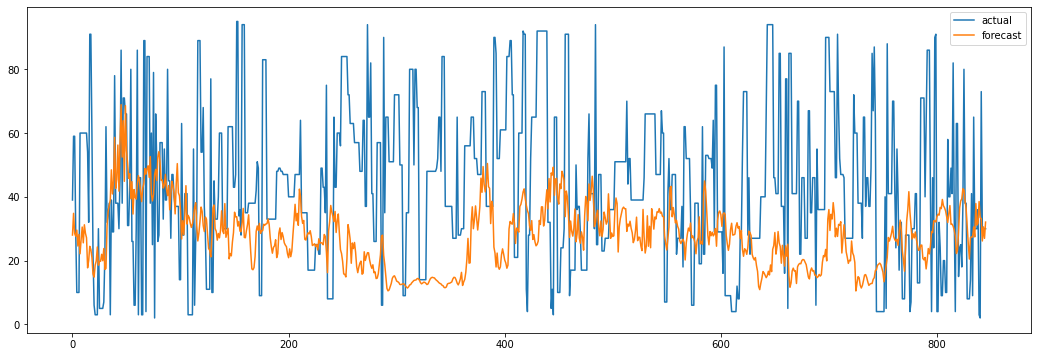

In [23]:
## with randomized graph

x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    # np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    # np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),

    np.square(np.nanmean(x_test[:, -1, :,0] - y[:, 0, :])),
    np.square(np.nanmean(y_pred[:, 0, :] - y[:, 0, :])),
)
print(f"naive MSE: {naive_mse}, model MSE: {model_mse}")

In [23]:
## this is to predict unrelated age from pollution -- of course it doesnt work -- hopefully good prevalence data will work better!